In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from datetime import datetime

In [179]:
def light_curve(low_path: str, high_path: str, unique_ids: list = None):

    low_df = pd.read_csv(low_path)
    high_df = pd.read_csv(high_path)
    if unique_ids == None:
        unique_ids = high_df['Source ID'].tolist()
    for source in unique_ids:
        plt.subplots()
        source_df = low_df[low_df['Source ID'] == source]
        fluxes = source_df['Flux Density']
        fluxes = [float(flux.replace('mJy', '')) for flux in fluxes]
        flux_errs = source_df['Flux Uncert']
        flux_errs = [float(err.replace('mJy', '')) for err in flux_errs]
        date_times = source_df['Obs Date Time']
        fmt_str = '%m-%d-%y %H:%M:%S'
        date_times = [Time(datetime.strptime(dt, fmt_str), format='datetime', scale='utc').mjd for dt in date_times]
        freqs = source_df['Freq'].tolist()
        other = []
        milli = []
        micro = []
        for i in range(len(freqs)):
            if freqs[i] == 'Not found':
                other.append(i)
                pass
            else:
                try:
                    freqs[i] = float(freqs[i].replace('GHz', ''))
                    if freqs[i] > 214 and freqs[i] < 273:
                        milli.append(i)
                    elif freqs[i] > 340 and freqs[i] < 355:
                        micro.append(i)
                    else:
                        other.append(i)
                except Exception as e:
                    print(f'Error while getting the frequencies for source {source}: {e}')
        other_dt = [date_times[a] for a in other]
        other_flx = [fluxes[a] for a in other]
        other_flx_err = [flux_errs[a] for a in other]
        milli_dt = [date_times[b] for b in milli]
        milli_flx = [fluxes[b] for b in milli]
        milli_flx_err = [flux_errs[b] for b in milli]
        micro_dt = [date_times[c] for c in micro]
        micro_flx = [fluxes[c] for c in micro]
        micro_flx_err = [flux_errs[c] for c in micro]
        if other != []:
            plt.errorbar(other_dt, other_flx, yerr=other_flx_err, color='b', fmt='x', capsize=3,\
                        capthick=0.35, elinewidth=0.35)
        if milli != []:
            plt.errorbar(milli_dt, milli_flx, yerr=milli_flx_err, color='r', fmt='x', capsize=3,\
                        capthick=0.35, elinewidth=0.35)
        if micro != []:
            plt.errorbar(micro_dt, micro_flx, yerr=micro_flx_err, color='g', fmt='x', capsize=3,\
                        capthick=0.35, elinewidth=0.35)


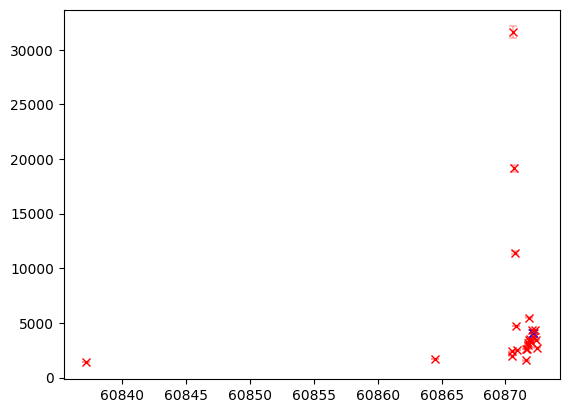

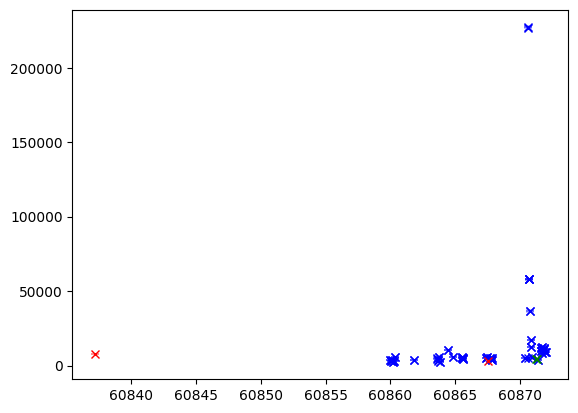

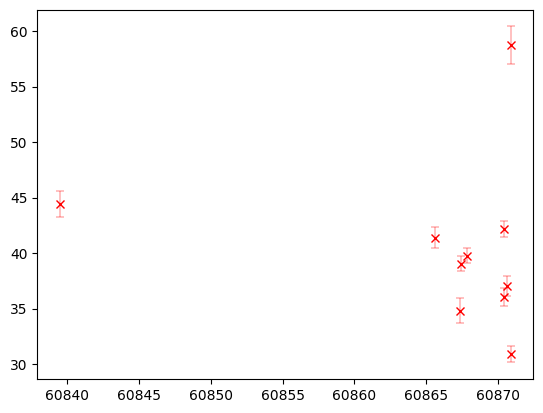

In [180]:
light_curve('./low_level.csv', './high_level.csv', ['id0001', 'id0004', 'id0048'])